# Biology & Omics Showcase

Five standard datasets commonly used with ComplexHeatmap in biology and omics research.

| # | Use Case | Data Type | Key Features |
|---|----------|-----------|-------------|
| 1 | **RNA-seq Gene Expression** | Bulk transcriptomics | Row z-score, sample metadata, pathway split |
| 2 | **DNA Methylation** | Epigenomics (450K array) | Beta values 0–1, CpG island context, tumor vs normal |
| 3 | **Proteomics (Mass Spec)** | Quantitative proteomics | Log2 fold-change, violin replicates, protein complexes |
| 4 | **Single-Cell Marker Genes** | scRNA-seq | Mean expression per cluster, cell-type annotations |
| 5 | **Metabolomics** | Clinical metabolomics | Concentration z-scores, pathway bars, patient metadata |

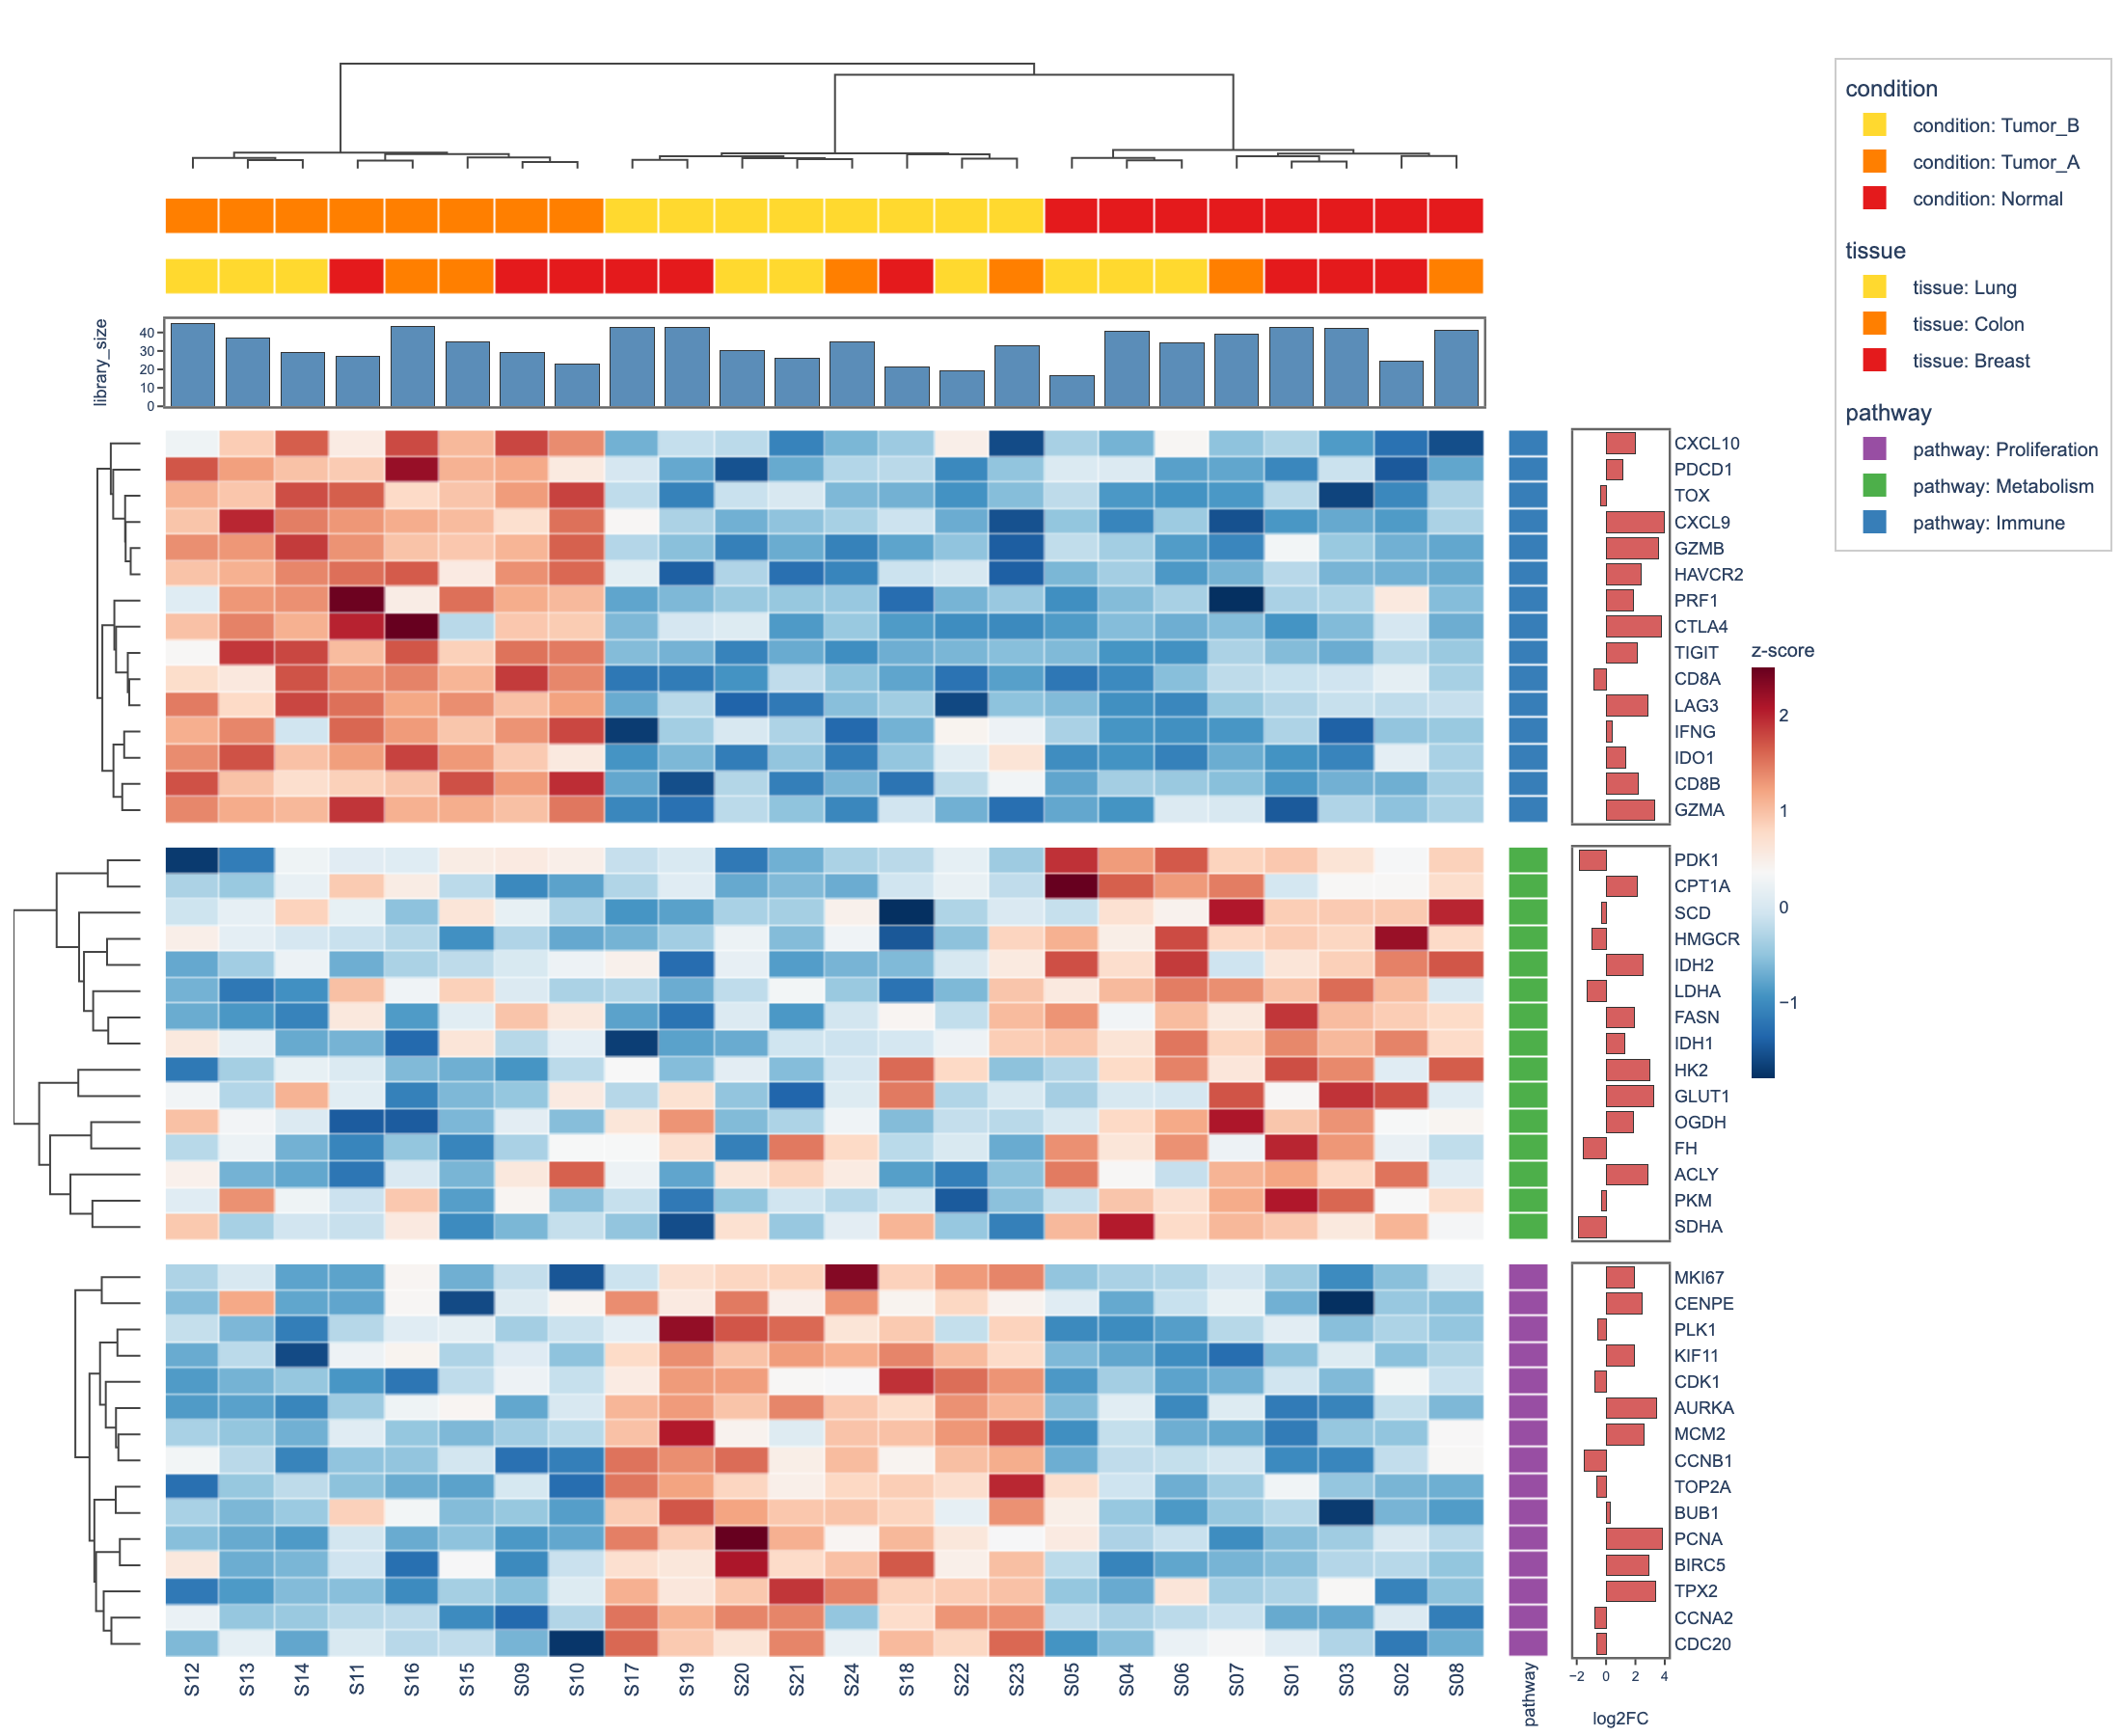

In [1]:
# ---------- 1. RNA-seq Gene Expression (Bulk Transcriptomics) ----------
#
# Classic use case: differentially expressed genes across conditions.
# Simulates a cancer vs normal experiment with 3 tissue subtypes.
# Row-normalised z-scores, split by functional pathway.

import numpy as np
import pandas as pd
from plotly_complexheatmap import ComplexHeatmap, HeatmapAnnotation

rng = np.random.default_rng(2024)

# Gene names: real cancer-related genes
genes_immune = ["CD8A", "CD8B", "GZMA", "GZMB", "PRF1", "IFNG", "CXCL9", "CXCL10",
                "IDO1", "LAG3", "PDCD1", "CTLA4", "TIGIT", "HAVCR2", "TOX"]
genes_prolif = ["MKI67", "TOP2A", "PCNA", "MCM2", "CDK1", "CCNB1", "CCNA2", "AURKA",
                "BUB1", "CDC20", "PLK1", "KIF11", "CENPE", "TPX2", "BIRC5"]
genes_metabolism = ["LDHA", "HK2", "PKM", "GLUT1", "PDK1", "ACLY", "FASN", "SCD",
                    "CPT1A", "HMGCR", "IDH1", "IDH2", "OGDH", "SDHA", "FH"]
all_genes = genes_immune + genes_prolif + genes_metabolism
pathways = ["Immune"] * 15 + ["Proliferation"] * 15 + ["Metabolism"] * 15

n_genes = len(all_genes)
n_samples = 24

# 24 samples: 8 Normal, 8 Tumor_A (immune-hot), 8 Tumor_B (proliferative)
conditions = ["Normal"] * 8 + ["Tumor_A"] * 8 + ["Tumor_B"] * 8
tissues = (["Breast"] * 3 + ["Lung"] * 3 + ["Colon"] * 2) * 3

# Base expression + condition-specific signals
expr = rng.standard_normal((n_genes, n_samples)) * 0.8
expr[:15, 8:16] += 3.0   # immune genes up in Tumor_A
expr[15:30, 16:] += 2.5  # proliferation genes up in Tumor_B
expr[30:, :8] += 1.5     # metabolism genes higher in Normal

df_rnaseq = pd.DataFrame(expr, index=all_genes,
                         columns=[f"S{i+1:02d}" for i in range(n_samples)])

# Annotations
top_ha = HeatmapAnnotation(
    condition=conditions,
    tissue=tissues,
    library_size={"values": rng.uniform(15, 45, n_samples), "type": "bar", "color": "#5B8DB8"},
)
right_ha = HeatmapAnnotation(
    pathway=pathways,
    log2FC={"values": rng.uniform(-2, 4, n_genes), "type": "bar", "color": "#D65F5F"},
    which="row",
)

hm1 = ComplexHeatmap(
    df_rnaseq,
    top_annotation=top_ha,
    right_annotation=right_ha,
    split_rows_by="pathway",
    colorscale="RdBu_r",
    normalize="row",
    name="z-score",
    cluster_metric="correlation",
    width=1100,
    height=900,
)
hm1.to_plotly()

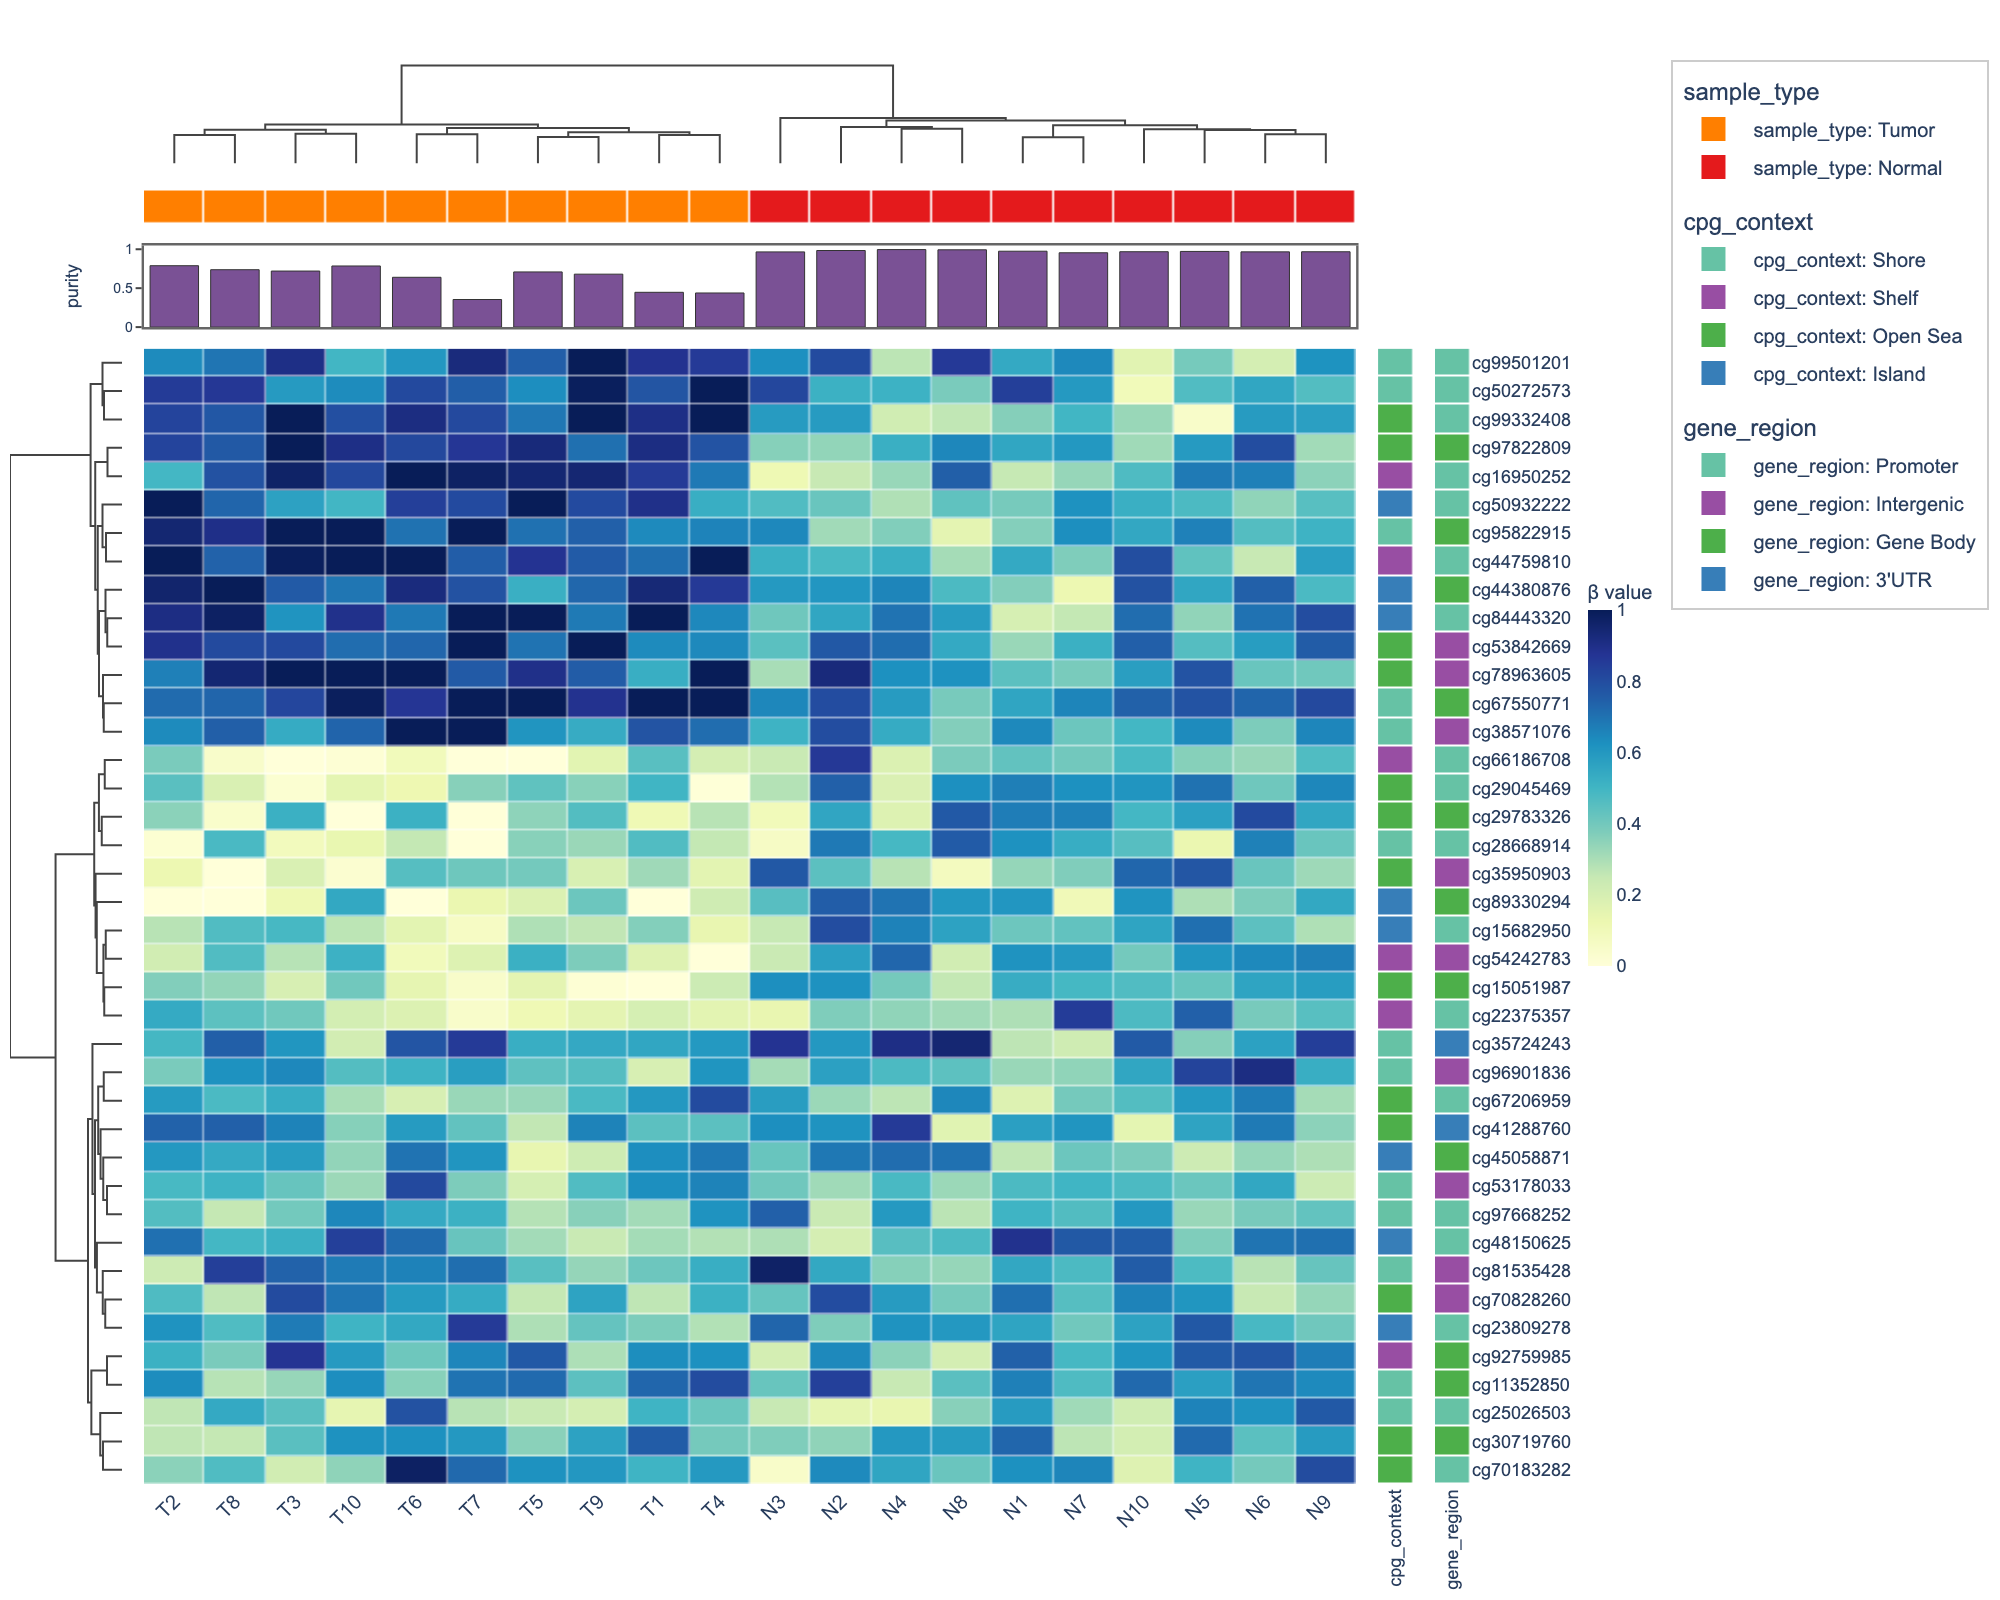

In [2]:
# ---------- 2. DNA Methylation (Epigenomics) ----------
#
# CpG methylation beta values (0 = unmethylated, 1 = fully methylated).
# Simulates differentially methylated regions in cancer.
# Sequential colorscale (YlGnBu) appropriate for 0–1 bounded data.

rng2 = np.random.default_rng(2025)

n_cpg = 40
n_meth_samples = 20

# CpG probe names (Illumina 450K style)
cpg_ids = [f"cg{rng2.integers(10000000, 99999999)}" for _ in range(n_cpg)]

# Sample layout: 10 Normal, 10 Tumor
sample_type = ["Normal"] * 10 + ["Tumor"] * 10
sample_names = [f"N{i+1}" for i in range(10)] + [f"T{i+1}" for i in range(10)]

# CpG context: Island, Shore, Shelf, Open Sea
cpg_context = rng2.choice(["Island", "Shore", "Shelf", "Open Sea"],
                          size=n_cpg, p=[0.35, 0.25, 0.2, 0.2])

# Gene region context
gene_region = rng2.choice(["Promoter", "Gene Body", "3'UTR", "Intergenic"],
                          size=n_cpg, p=[0.4, 0.3, 0.1, 0.2])

# Beta values: baseline around 0.3–0.7, with hyper/hypo-methylation in tumor
beta = rng2.beta(3, 3, size=(n_cpg, n_meth_samples))
# Hypermethylation in tumor for island CpGs (rows 0–14)
beta[:14, 10:] = np.clip(beta[:14, 10:] + 0.35, 0, 1)
# Hypomethylation in tumor for open-sea CpGs (rows 30–39)
beta[30:, 10:] = np.clip(beta[30:, 10:] - 0.30, 0, 1)

df_meth = pd.DataFrame(beta, index=cpg_ids, columns=sample_names)

top_ha2 = HeatmapAnnotation(
    sample_type=sample_type,
    purity={"values": np.concatenate([rng2.uniform(0.95, 1.0, 10),
                                      rng2.uniform(0.3, 0.9, 10)]),
            "type": "bar", "color": "#7A5195"},
)
right_ha2 = HeatmapAnnotation(
    cpg_context=cpg_context.tolist(),
    gene_region=gene_region.tolist(),
    which="row",
)

hm2 = ComplexHeatmap(
    df_meth,
    top_annotation=top_ha2,
    right_annotation=right_ha2,
    colorscale="YlGnBu",
    normalize="none",
    name="\u03b2 value",
    cluster_metric="euclidean",
    width=1000,
    height=800,
)
hm2.to_plotly()

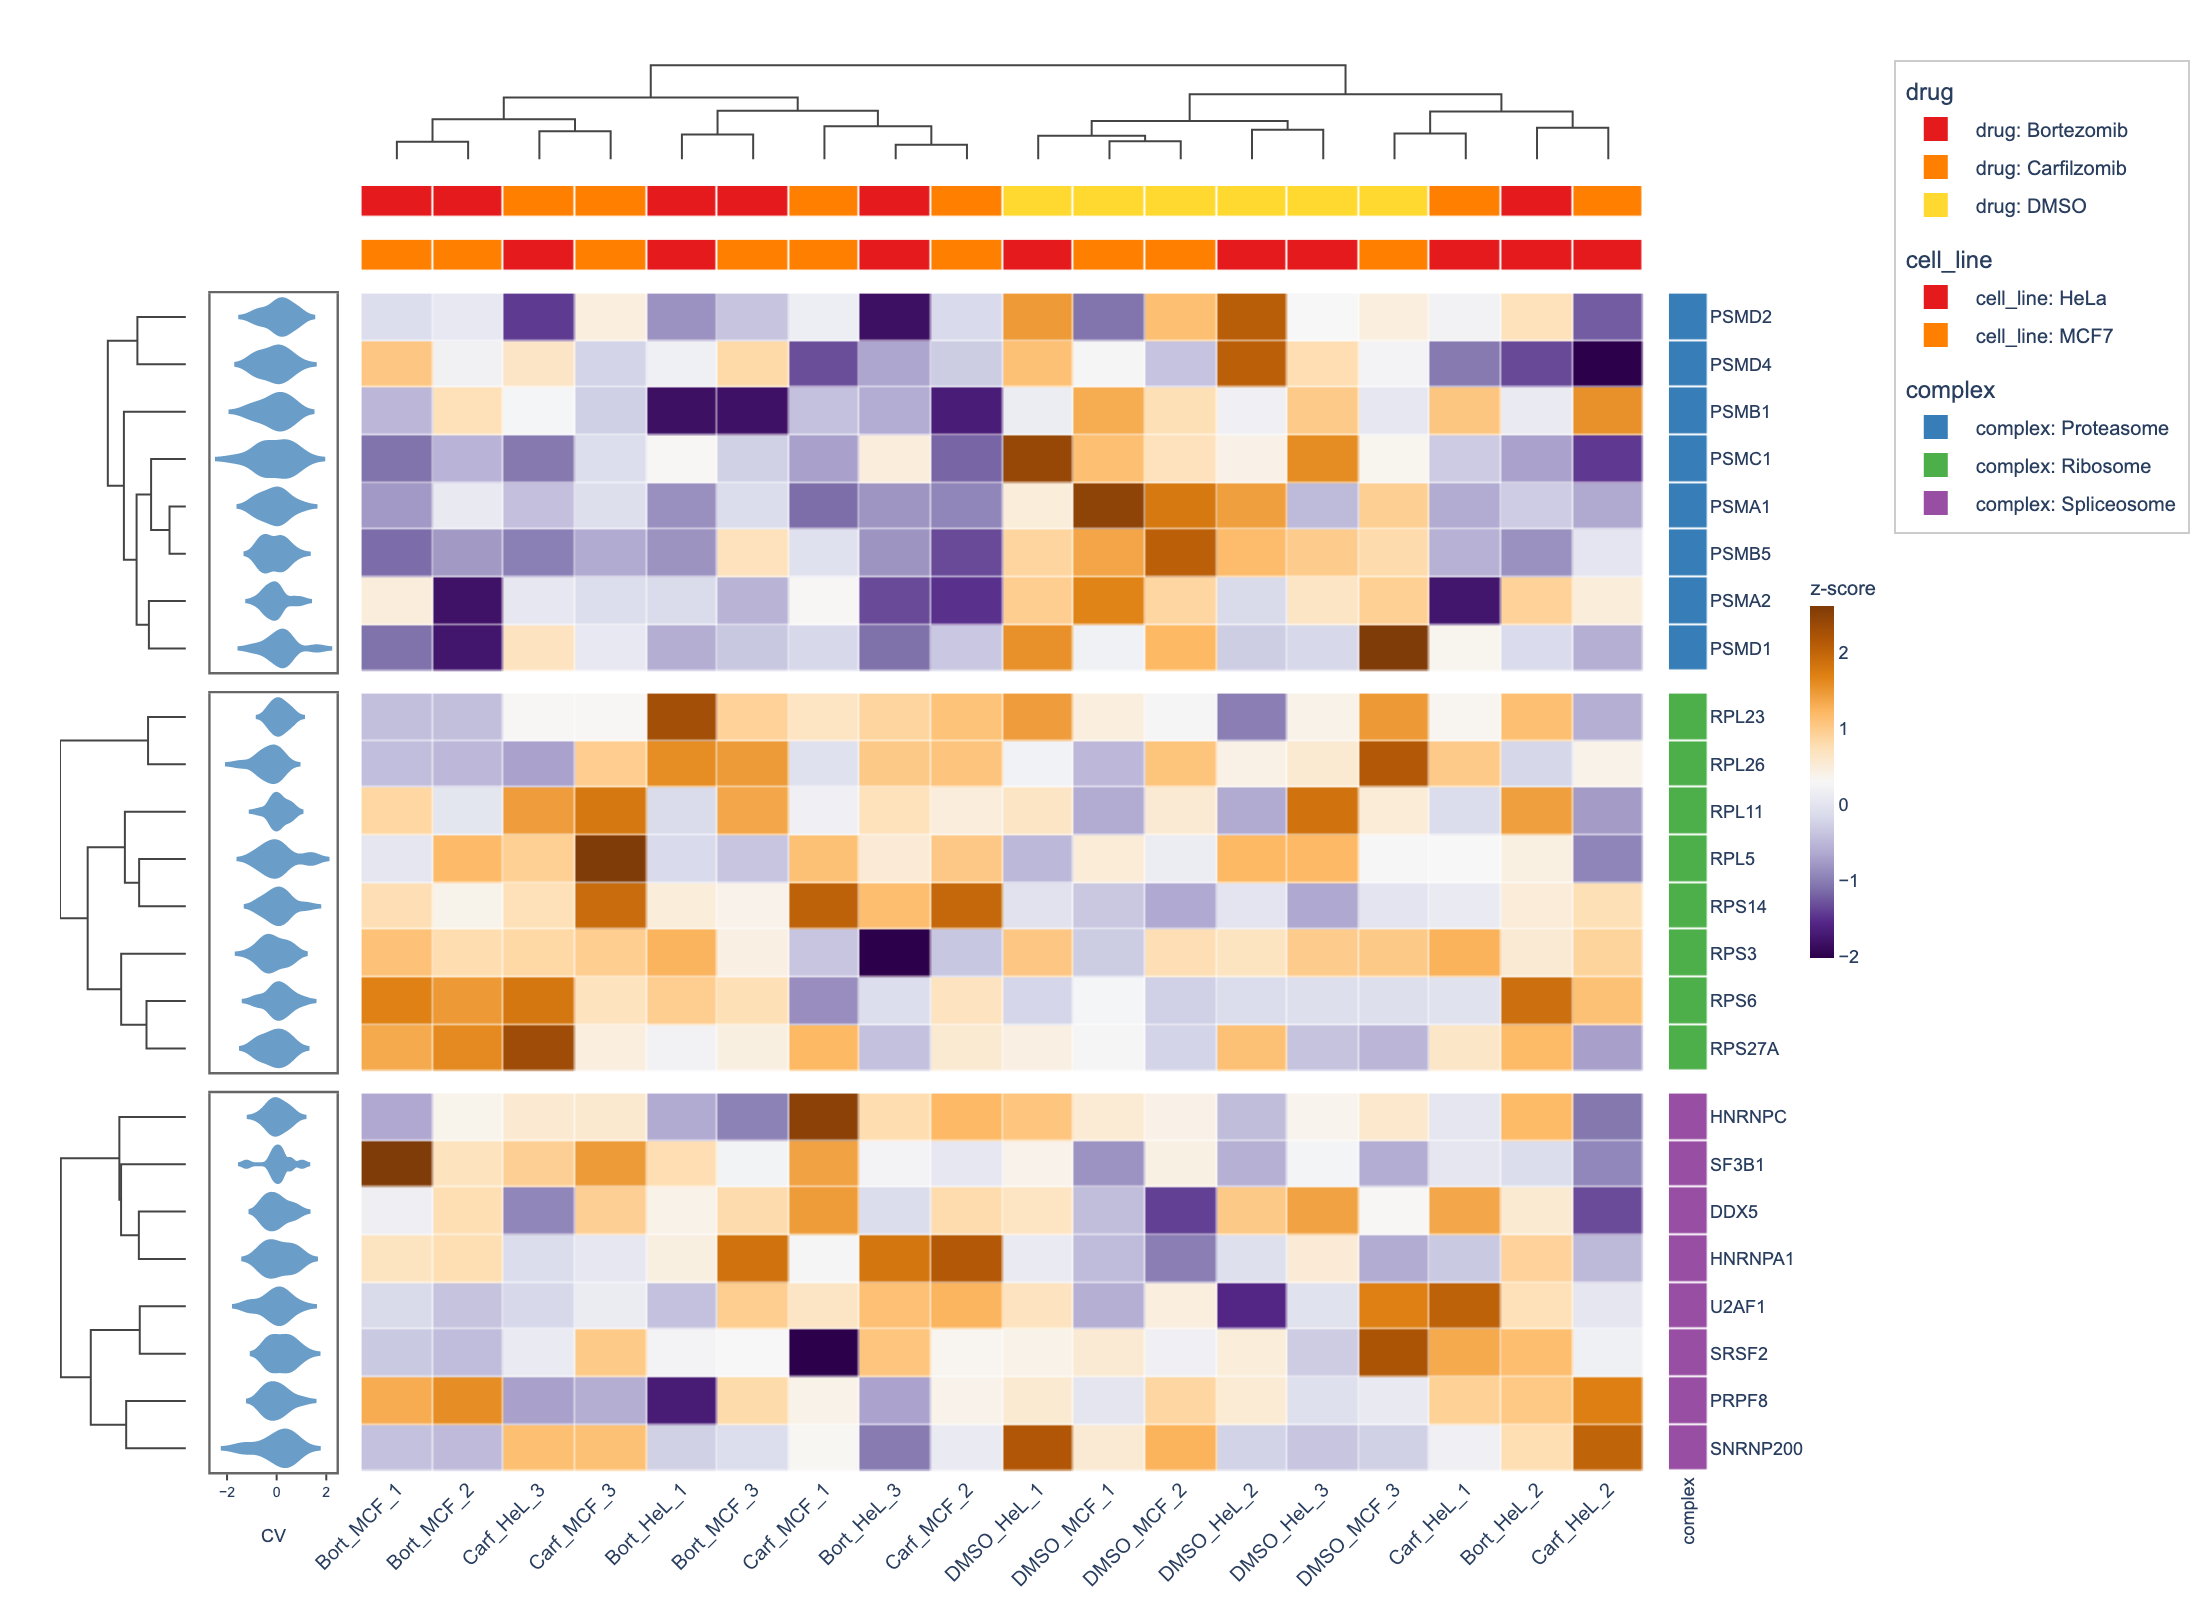

In [3]:
# ---------- 3. Quantitative Proteomics (Mass Spectrometry) ----------
#
# Log2 protein intensities across drug-treated cell lines.
# Violin annotations show replicate distributions.
# Split by protein complex membership.

rng3 = np.random.default_rng(2026)

# Proteins from well-known complexes
proteasome = ["PSMA1", "PSMA2", "PSMB1", "PSMB5", "PSMC1", "PSMD1", "PSMD2", "PSMD4"]
ribosome = ["RPL5", "RPL11", "RPS3", "RPS6", "RPS14", "RPL23", "RPL26", "RPS27A"]
spliceosome = ["SF3B1", "U2AF1", "SRSF2", "PRPF8", "SNRNP200", "DDX5", "HNRNPA1", "HNRNPC"]
all_proteins = proteasome + ribosome + spliceosome
complexes = ["Proteasome"] * 8 + ["Ribosome"] * 8 + ["Spliceosome"] * 8
n_prot = len(all_proteins)

# 18 samples: 3 drugs × 2 cell lines × 3 replicates
n_prot_samples = 18
drugs = ["DMSO"] * 6 + ["Bortezomib"] * 6 + ["Carfilzomib"] * 6
cell_lines = (["HeLa"] * 3 + ["MCF7"] * 3) * 3
sample_labels = [f"{d[:4]}_{c[:3]}_{r+1}" for d, c, r in
                 zip(drugs, cell_lines, list(range(3)) * 6)]

# Log2 intensity: baseline ~22–28, drug effects on proteasome
log2_int = rng3.normal(25, 1.5, (n_prot, n_prot_samples))
log2_int[:8, 6:] -= 3.0    # proteasome down with proteasome inhibitors
log2_int[8:16, 6:] += 1.0  # ribosome compensatory up-regulation

df_prot = pd.DataFrame(log2_int, index=all_proteins, columns=sample_labels)

# Violin: replicate variability per protein (simulate 15 technical replicates)
violin_reps = rng3.normal(0, 0.5, (n_prot, 15))

top_ha3 = HeatmapAnnotation(
    drug=drugs,
    cell_line=cell_lines,
)
left_ha3 = HeatmapAnnotation(
    CV={"values": violin_reps, "type": "violin", "color": "#6A9EC9"},
    which="row",
)
right_ha3 = HeatmapAnnotation(
    complex=complexes,
    which="row",
)

hm3 = ComplexHeatmap(
    df_prot,
    top_annotation=top_ha3,
    left_annotation=left_ha3,
    right_annotation=right_ha3,
    split_rows_by="complex",
    colorscale="PuOr_r",
    normalize="row",
    name="z-score",
    cluster_metric="correlation",
    width=1100,
    height=800,
)
hm3.to_plotly()

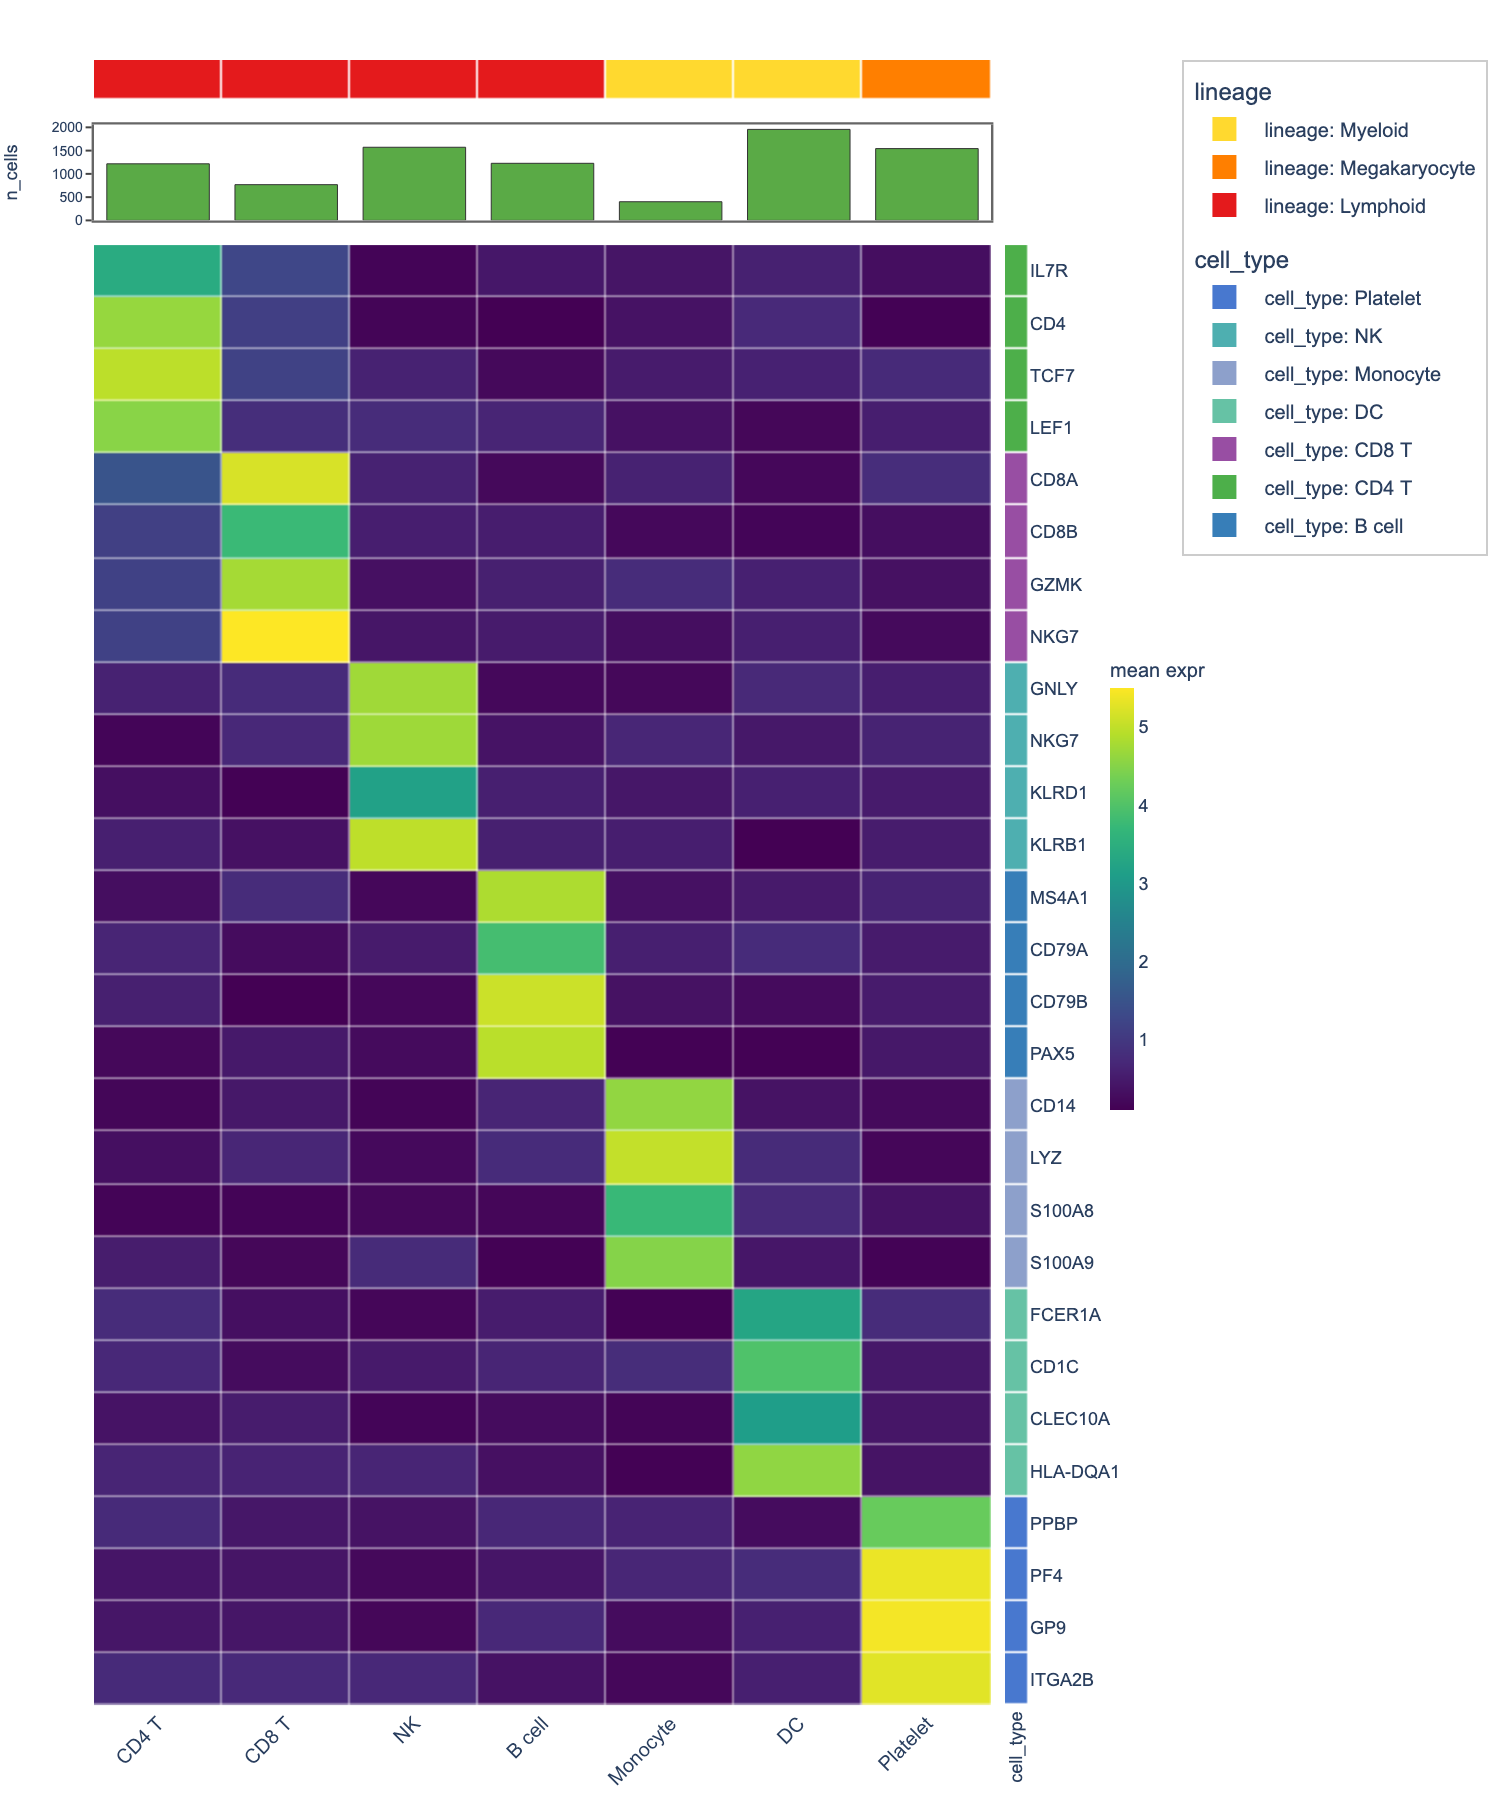

In [4]:
# ---------- 4. Single-Cell Marker Genes (scRNA-seq) ----------
#
# Mean expression of known marker genes per cell cluster.
# Classic dot-plot alternative used in scRNA-seq papers (Seurat/Scanpy style).
# No row/col clustering — genes and clusters are in biological order.

rng4 = np.random.default_rng(2027)

# Cell type clusters and their canonical markers
cluster_markers = {
    "CD4 T": ["IL7R", "CD4", "TCF7", "LEF1"],
    "CD8 T": ["CD8A", "CD8B", "GZMK", "NKG7"],
    "NK": ["GNLY", "NKG7", "KLRD1", "KLRB1"],
    "B cell": ["MS4A1", "CD79A", "CD79B", "PAX5"],
    "Monocyte": ["CD14", "LYZ", "S100A8", "S100A9"],
    "DC": ["FCER1A", "CD1C", "CLEC10A", "HLA-DQA1"],
    "Platelet": ["PPBP", "PF4", "GP9", "ITGA2B"],
}

clusters = list(cluster_markers.keys())
all_markers = [g for genes in cluster_markers.values() for g in genes]
n_markers = len(all_markers)
n_clusters = len(clusters)

# Cell type lineage annotation
lineage_map = {"CD4 T": "Lymphoid", "CD8 T": "Lymphoid", "NK": "Lymphoid",
               "B cell": "Lymphoid", "Monocyte": "Myeloid", "DC": "Myeloid",
               "Platelet": "Megakaryocyte"}
lineages = [lineage_map[c] for c in clusters]

# Build expression matrix: markers high in their own cluster, low elsewhere
mean_expr = rng4.uniform(0.1, 0.8, (n_markers, n_clusters))
marker_idx = 0
for ci, (ctype, markers) in enumerate(cluster_markers.items()):
    for mi in range(len(markers)):
        mean_expr[marker_idx + mi, ci] = rng4.uniform(3.0, 5.5)
        # slight cross-reactivity with related types
        if ctype in ["CD4 T", "CD8 T"]:
            other = 1 - ci if ci <= 1 else ci
            mean_expr[marker_idx + mi, other] += rng4.uniform(0.5, 1.5)
    marker_idx += len(markers)

df_sc = pd.DataFrame(mean_expr, index=all_markers, columns=clusters)

# Number of cells per cluster (for bar annotation)
n_cells = rng4.integers(200, 3000, n_clusters).astype(float)

top_ha4 = HeatmapAnnotation(
    lineage=lineages,
    n_cells={"values": n_cells, "type": "bar", "color": "#5AAA46"},
)

# Gene-level: which cluster each marker belongs to
marker_cluster = [c for c, markers in cluster_markers.items() for _ in markers]
right_ha4 = HeatmapAnnotation(
    cell_type=marker_cluster,
    which="row",
)

hm4 = ComplexHeatmap(
    df_sc,
    top_annotation=top_ha4,
    right_annotation=right_ha4,
    cluster_rows=False,   # keep biological marker order
    cluster_cols=False,   # keep cluster order
    colorscale="Viridis",
    normalize="none",
    name="mean expr",
    width=750,
    height=900,
)
hm4.to_plotly()

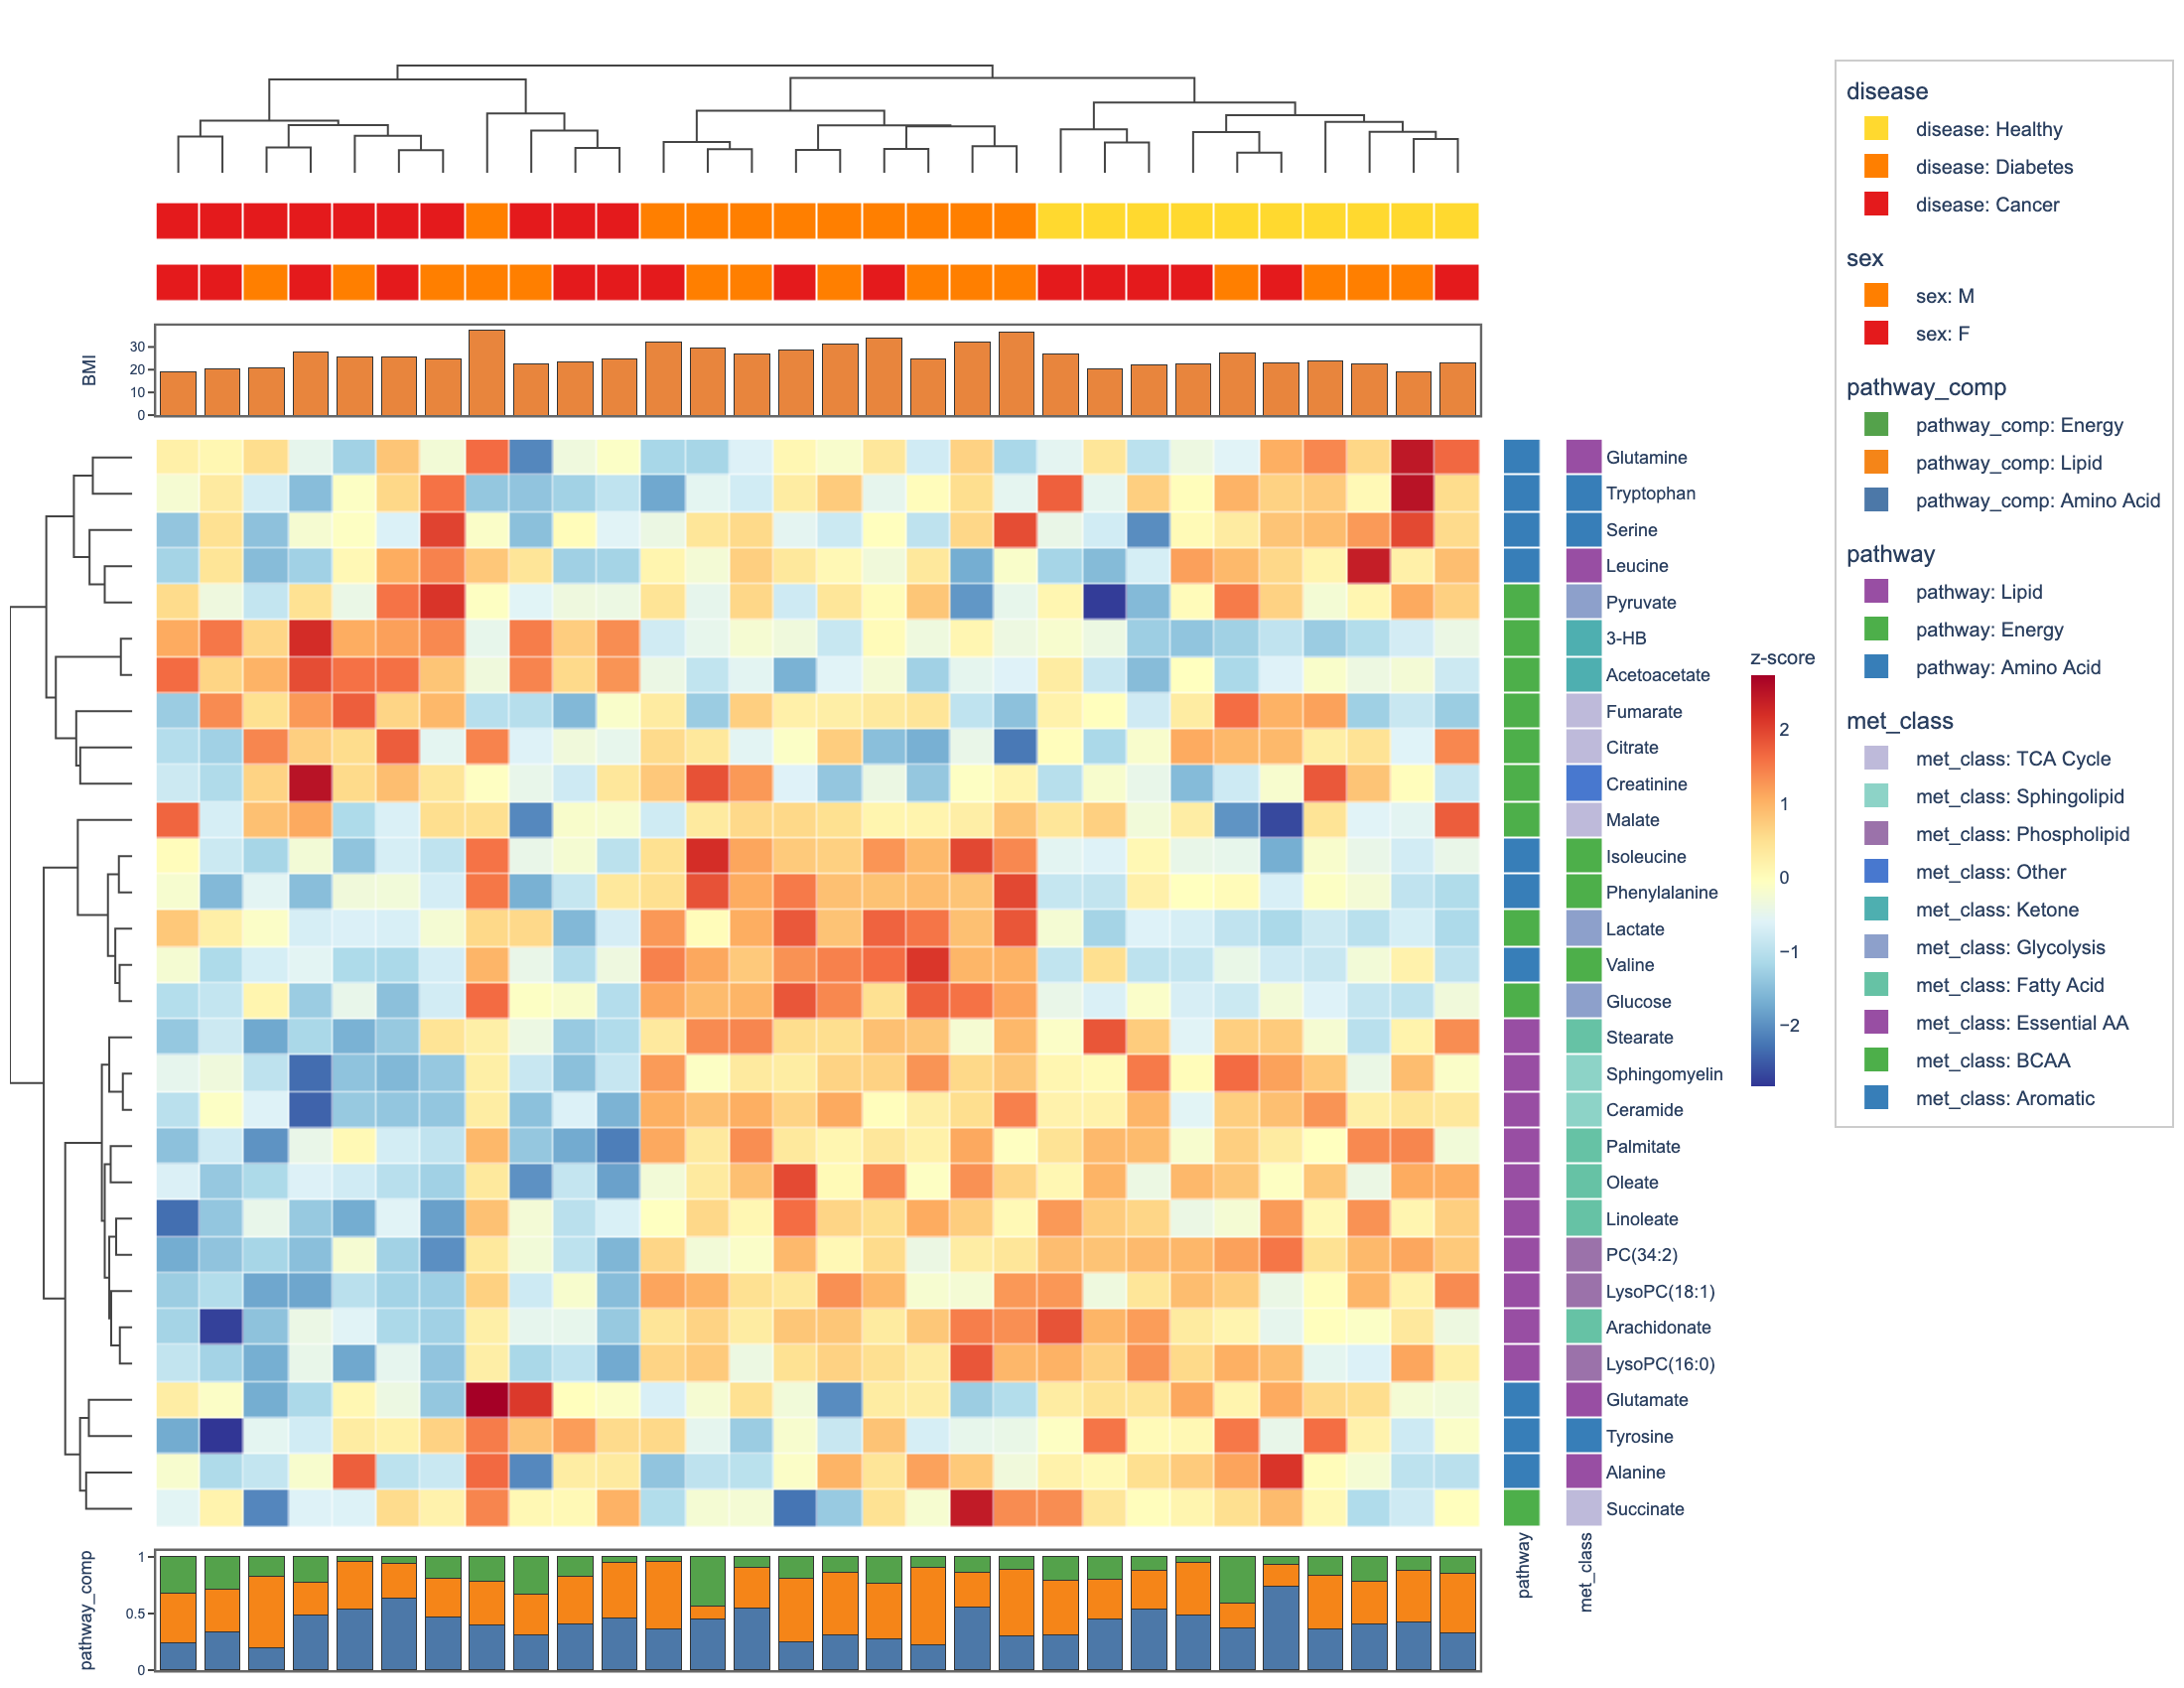

In [5]:
# ---------- 5. Clinical Metabolomics ----------
#
# Serum metabolite concentrations in a clinical cohort.
# Patients grouped by disease status; metabolites annotated by pathway and class.
# Stacked bars show pathway composition per patient.

rng5 = np.random.default_rng(2028)

# Metabolites from major pathways
aa_metabolites = ["Alanine", "Glutamine", "Glutamate", "Leucine", "Isoleucine",
                  "Valine", "Phenylalanine", "Tyrosine", "Tryptophan", "Serine"]
lipid_metabolites = ["Palmitate", "Stearate", "Oleate", "Linoleate", "Arachidonate",
                     "Sphingomyelin", "Ceramide", "LysoPC(16:0)", "LysoPC(18:1)", "PC(34:2)"]
energy_metabolites = ["Glucose", "Lactate", "Pyruvate", "Citrate", "Succinate",
                      "Fumarate", "Malate", "3-HB", "Acetoacetate", "Creatinine"]

all_metabolites = aa_metabolites + lipid_metabolites + energy_metabolites
met_pathway = ["Amino Acid"] * 10 + ["Lipid"] * 10 + ["Energy"] * 10
met_class = (["Essential AA"] * 4 + ["BCAA"] * 3 + ["Aromatic"] * 3 +
             ["Fatty Acid"] * 5 + ["Sphingolipid"] * 2 + ["Phospholipid"] * 3 +
             ["Glycolysis"] * 3 + ["TCA Cycle"] * 4 + ["Ketone"] * 2 + ["Other"] * 1)
n_met = len(all_metabolites)

# 30 patients: 10 Healthy, 10 Diabetes, 10 Cancer
n_patients = 30
disease = ["Healthy"] * 10 + ["Diabetes"] * 10 + ["Cancer"] * 10
sex = rng5.choice(["M", "F"], n_patients).tolist()
age = rng5.integers(35, 75, n_patients).astype(float)
bmi = np.concatenate([
    rng5.normal(23, 2, 10),   # Healthy
    rng5.normal(31, 3, 10),   # Diabetes
    rng5.normal(22, 3, 10),   # Cancer
])

patient_labels = [f"P{i+1:02d}" for i in range(n_patients)]

# Concentration data with disease-specific signatures
conc = rng5.standard_normal((n_met, n_patients)) * 0.6
# Diabetes: elevated BCAAs (Leucine, Isoleucine, Valine) and glucose
conc[4:7, 10:20] += 2.5   # BCAAs
conc[20, 10:20] += 3.0    # Glucose
conc[21, 10:20] += 2.0    # Lactate
# Cancer: altered lipids and ketone bodies
conc[10:20, 20:] -= 1.8   # Lipids down
conc[27:29, 20:] += 2.5   # Ketone bodies up
# Healthy: balanced amino acids
conc[:10, :10] += 0.5

df_met = pd.DataFrame(conc, index=all_metabolites, columns=patient_labels)

# Pathway composition per patient (stacked bar)
pathway_comp = rng5.dirichlet([3, 4, 2], n_patients)

top_ha5 = HeatmapAnnotation(
    disease=disease,
    sex=sex,
    BMI={"values": bmi, "type": "bar", "color": "#E8853D"},
)
bottom_ha5 = HeatmapAnnotation(
    pathway_comp={
        "values": pathway_comp,
        "type": "stacked_bar",
        "stack_names": ["Amino Acid", "Lipid", "Energy"],
        "colors": ["#4C78A8", "#F58518", "#54A24B"],
    },
)
right_ha5 = HeatmapAnnotation(
    pathway=met_pathway,
    met_class=met_class,
    which="row",
)

hm5 = ComplexHeatmap(
    df_met,
    top_annotation=top_ha5,
    bottom_annotation=bottom_ha5,
    right_annotation=right_ha5,
    colorscale="RdYlBu_r",
    normalize="row",
    name="z-score",
    cluster_method="complete",
    cluster_metric="correlation",
    width=1100,
    height=850,
)
hm5.to_plotly()